In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx 
from shapely import distance
from pyproj import Transformer
from shapely.geometry import LineString
import shapely.ops as sp_ops
import warnings
warnings.filterwarnings("ignore")
import itertools
from shapely import buffer  

In [2]:
main_folder_path =os.path.normpath(os.getcwd() + os.sep + os.pardir)
df =pd.read_csv(main_folder_path+"\\data\\_roads3.csv")

In [3]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")

In [4]:
road_names =gdf["road"].unique()
road_names_N1= [road for road in road_names if road.startswith("N")]
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3857', always_xy=True)
line_dict = {}
line_dict_test = {}
for road_name in road_names_N1:
    bridges_road = gdf[gdf["road"] == road_name]
    if len(bridges_road["geometry"]) >= 2:
            line =LineString(bridges_road["geometry"])
            line_transformed = sp_ops.transform(transformer.transform ,line).length
            if line_transformed > 25000:
                line_dict[road_name] =buffer(LineString(bridges_road["geometry"]),0.01)
                line_dict_test[road_name] =line

gseries =gpd.GeoSeries(line_dict.values(), index=line_dict.keys(), crs=4326)
gseries_test =gpd.GeoSeries(line_dict_test.values(), index=line_dict_test.keys(), crs=4326)

In [5]:
cross_index_N1=[]
for index in gseries.index:
    if gseries["N1"].intersects(gseries[index]):
        cross_index_N1.append(index)
cross_index_N2=[]
for index in gseries.index:
    if gseries["N2"].intersects(gseries[index]):
        cross_index_N2.append(index)

intersecting_N1 =gseries[gseries.index.isin(cross_index_N1)]
intersecting_N2 =gseries[gseries.index.isin(cross_index_N2)]

intersections_N1 =gseries["N1"].intersection(intersecting_N1).drop("N1")
intersections_N2 =gseries["N2"].intersection(intersecting_N2).drop("N2")

gdf_N1 =gdf[gdf["road"]=="N1"]
gdf_N2 =gdf[gdf["road"]=="N2"]

In [6]:
pd.concat([intersections_N1,intersections_N2]).to_csv(main_folder_path + "\\data\\intersections_BONUS.csv")


In [7]:
def process_intersection_data(gdf_data, intersect_data):
    df_list = []
    index_list = []
    closest_points = []
    empty_dataframe = gpd.GeoDataFrame(columns=list(gdf.columns)+["intersec_to"],crs="EPSG:4326")

    for intersect_index_N1 in intersect_data.index:
        intersect_point_N1 = intersect_data[intersect_index_N1]
        min_dist = 10000

        for N1_index in gdf_data.index:
            N1_point = gdf_data.loc[N1_index, "geometry"]
            dist = distance(N1_point, intersect_point_N1)

            if dist < min_dist:
                min_dist = dist
                closest_point = N1_index
        series = gdf_data.loc[closest_point]
        series["intersec_to"]=intersect_index_N1    
        empty_dataframe.loc[closest_point]=series


        index_list.append(intersect_index_N1)
        closest_points.append(closest_point)
    
    
    empty_dataframe["type"] = "intersection"
    
    return empty_dataframe

df_intersections_main_N1 = process_intersection_data(gdf_N1, intersections_N1)

df_intersections_main_N2 = process_intersection_data(gdf_N2, intersections_N2)
df_intersections_main =pd.concat([df_intersections_main_N1,df_intersections_main_N2], axis=0, ignore_index=True)
df_intersections_main.to_csv(main_folder_path+"\\data\\intersections_main.csv")

In [8]:
Side_to_N1 = gpd.GeoDataFrame(columns=list(gdf.columns)+["intersec_to"],crs="EPSG:4326")
for road_name in intersections_N1.index:
    road_gdf = gdf[gdf["road"]==road_name]
    intersect_point_N1 =intersections_N1[road_name]
    min_dist=10000
    for road_point_index in road_gdf.index:
        road_point =road_gdf.loc[road_point_index,"geometry"]
        dist =distance(intersect_point_N1,road_point)
        if  dist< min_dist:
            min_dist = dist
            closest_point =road_point_index
    series = road_gdf.loc[closest_point]
    series["intersec_to"]="N1"   
    Side_to_N1.loc[closest_point]=series


Side_to_N2 = gpd.GeoDataFrame(columns=list(gdf.columns)+["intersec_to"],crs="EPSG:4326")
for road_name in intersections_N2.index:
    road_gdf = gdf[gdf["road"]==road_name]
    intersect_point_N2 =intersections_N2[road_name]
    min_dist=10000
    for road_point_index in road_gdf.index:
        road_point =road_gdf.loc[road_point_index,"geometry"]
        dist =distance(intersect_point_N2,road_point)
        if  dist< min_dist:
            min_dist = dist
            closest_point =road_point_index
    series = road_gdf.loc[closest_point]
    series["intersec_to"]="N2"   
    Side_to_N2.loc[closest_point]=series
 
df_intersections_side = pd.concat([Side_to_N1,Side_to_N2], axis=0, ignore_index=True)
df_intersections_side["type"]= "intersection"

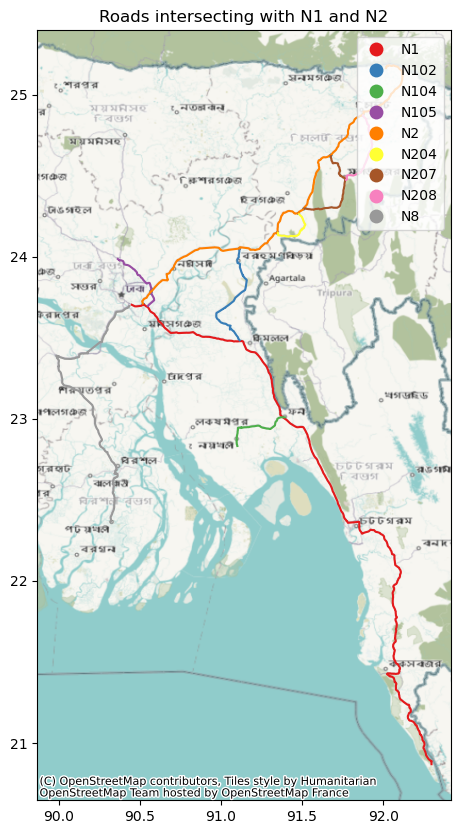

In [9]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

roads_plot = gseries_test[gseries_test.index.isin(df_intersections_main["intersec_to"])]
df_roads_plot =gseries_test[gseries_test.index.isin(df_intersections_main["intersec_to"])].reset_index()
df_roads_plot.plot(ax=ax,cmap="Set1",column="index",legend=True)
intersections_N2.plot(ax=ax)

cx.add_basemap(ax=ax,crs="EPSG:4326")
ax.title.set_text("Roads intersecting with N1 and N2")


In [10]:
gdf_N208 = gdf[gdf["road"]=="N208"]
gdf_N207 = gdf[gdf["road"] == "N207"]

In [11]:
gdf_N208_closest_point = gdf_N208.loc[3512]
gdf_N208_closest_point["intersec_to"]="N207"

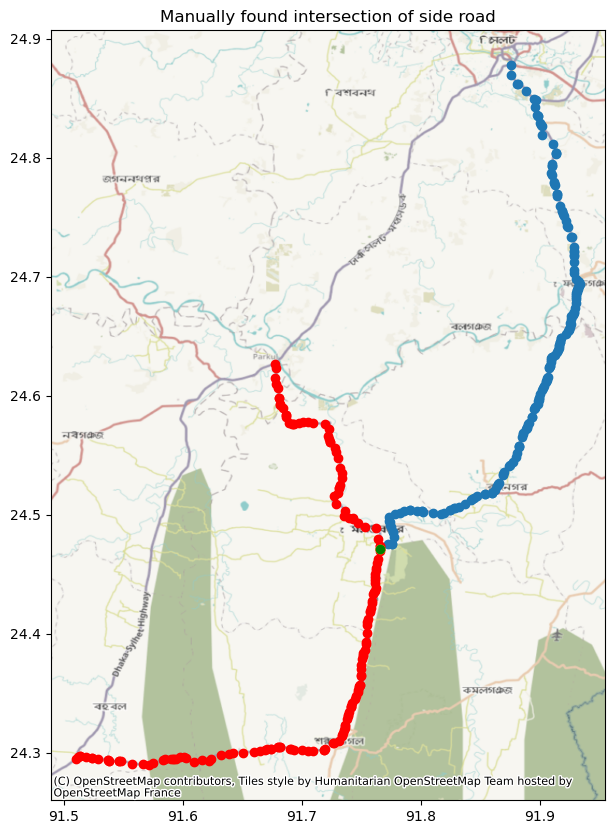

In [12]:
min_dist = 10000
for N1_index in gdf_N207.index:
    N1_point = gdf_N207.loc[N1_index, "geometry"]
    dist = distance(N1_point, gdf_N208_closest_point.loc["geometry"])

    if dist < min_dist:
        min_dist = dist
        closest_point = N1_index
gdf_N207_closest_point= gdf_N207.loc[closest_point]
gdf_N207_closest_point["intersec_to"]="N208"

fig,ax = plt.subplots(1,1,figsize=(10,10))
gdf_N208.plot(ax=ax)
gdf_N207.plot(ax=ax,color="red")
gpd.GeoSeries(gdf_N208_closest_point.loc["geometry"],crs="EPSG:4326").plot(ax=ax,color="yellow")
gpd.GeoSeries(gdf_N207_closest_point.loc["geometry"],crs="EPSG:4326").plot(ax=ax,color="green")
ax.title.set_text("Manually found intersection of side road")
cx.add_basemap(ax=ax,crs="EPSG:4326")


In [13]:
df_intersections_all =pd.concat([df_intersections_main,
                                 df_intersections_side,
                                 gpd.GeoDataFrame(gdf_N207_closest_point).T,
                                 gpd.GeoDataFrame(gdf_N208_closest_point).T],axis=0, ignore_index=True)

main_folder_path =os.path.normpath(os.getcwd() + os.sep + os.pardir)
df_intersections_all.to_csv(main_folder_path+"\\data\\intersections.csv")